# EDA ...

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
from pprint import pprint

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Parameters

In [4]:
SEED = 42

## Paths

### Input

In [5]:
RELATIVE_PATH = os.path.join("../", "data")

## Functions

In [58]:
def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)


def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel("Length of a sample")
    plt.ylabel("Number of samples")
    plt.title("Sample length distribution")
    plt.show()


def plot_frequency_distribution_of_ngrams(
    sample_texts, ngram_range=(1, 1), num_ngrams=50
):
    """Plots the frequency distribution of n-grams.

    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, max), The range of n-gram values to consider.
            min and max are the lower and the upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
        "ngram_range": ngram_range,
        "dtype": "int32",
        "strip_accents": "unicode",
        "decode_error": "replace",
        "analyzer": "word",  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # indices). This also converts every text to an array the length of
    # vocabulary, where every element represents the count of the n-gram
    # corresponding at that index in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names_out())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(
        *[(c, n) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)]
    )
    ngrams = list(all_ngrams)[:num_ngrams][::-1]
    counts = list(all_counts)[:num_ngrams][::-1]

    idx = np.arange(num_ngrams)

    f, ax = plt.subplots(figsize=(5, 8))
    plt.barh(idx, counts, align='center')
    plt.ylabel("Top {num_ngrams} N-grams".format(num_ngrams=num_ngrams))
    plt.xlabel("Frequencies")
    plt.title(
        "Frequency distribution of n-grams with range={ngram_range}".format(
            ngram_range=ngram_range
        )
    )
    plt.yticks(idx, ngrams)
    plt.margins(0.05, 0.01)
    plt.show()

## Loading data

In [7]:
class_col = "label"
text_col = "text"

In [8]:
reviews = pd.read_parquet(os.path.join(RELATIVE_PATH, "split_reviews.parquet"))
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206537 entries, 0 to 206536
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   label   206537 non-null  category
 1   text    206537 non-null  object  
 2   fold    206537 non-null  object  
dtypes: category(1), object(2)
memory usage: 3.3+ MB


## Analysis

### Check the Data

After loading the data, it’s good practice to run some checks on it: pick a few samples and manually check if they are consistent with your expectations. For example, print a few random samples to see if the sentiment label corresponds to the sentiment of the review.

In [9]:
for sentiment, text, _ in reviews.sample(5, random_state=SEED).values:
    print(f"Sentiment: {sentiment}")
    pprint(text, width=180)
    print("\n")

Sentiment: neutral
('Всем привет! Совсем недавно в российский прокат вышла заключительная часть приключений Тони Старка – «Железный человек 3». Самые стойкие, из тех, кого не смог завлечь шашлык и '
 'другие прелести первомая уже успели посмотреть этот фильм. Пришло время поделиться с вами своими впечатления, ведь, определенно, эта картина – одна из самых ожидаемых премьер '
 'года не только в России, но и во всем мире, оправдала ли она ожидания фанатов? Первая неделя принесла в копилку «Железного человека» более 300 млн. долларов, и это значит, что '
 'миллиардная отметка определенно покориться супергерою, а интерес со стороны зрителей колоссален. И Россия внесет существенный вклад в формировании кассовых сборов, ведь '
 'бронировать хорошие места в залах кинотеатров приходиться за несколько дней. Да, Железного человека любят в России, и первые две части франшизы, крутящиеся по ТВ собирают '
 'миллионы зрителей у голубых экранов. Но получилась ли третья часть столь же захватывающей и 

### Collect Key Metrics

Once we’ve verified the data, let's collect the following important metrics that can help characterize out text classification problem

**Number of samples**: Total number of examples you have in the data.

In [10]:
num_samples = reviews.shape[0]
num_samples

206537

**Number of classes**: Total number of topics or categories in the data.

In [11]:
num_classes = reviews["label"].nunique()
num_classes

3

**Number of samples per class**: Number of samples per class (topic/category).  
In a balanced dataset, all classes will have a similar number of samples; in an imbalanced dataset, the number of samples in each class will vary widely.

In [19]:
num_samples_per_class = reviews.groupby("label").agg({"text": "count"}).reset_index()
num_samples_per_class

,label,text
0,negative,26788
1,positive,148763
2,neutral,30986


**Number of words per sample**: Median number of words in one sample.

In [13]:
num_words_per_sample = get_num_words_per_sample(reviews["text"].values)
num_words_per_sample

315.0

**Distribution of sample length**: Distribution showing the number of words per sample in the dataset.

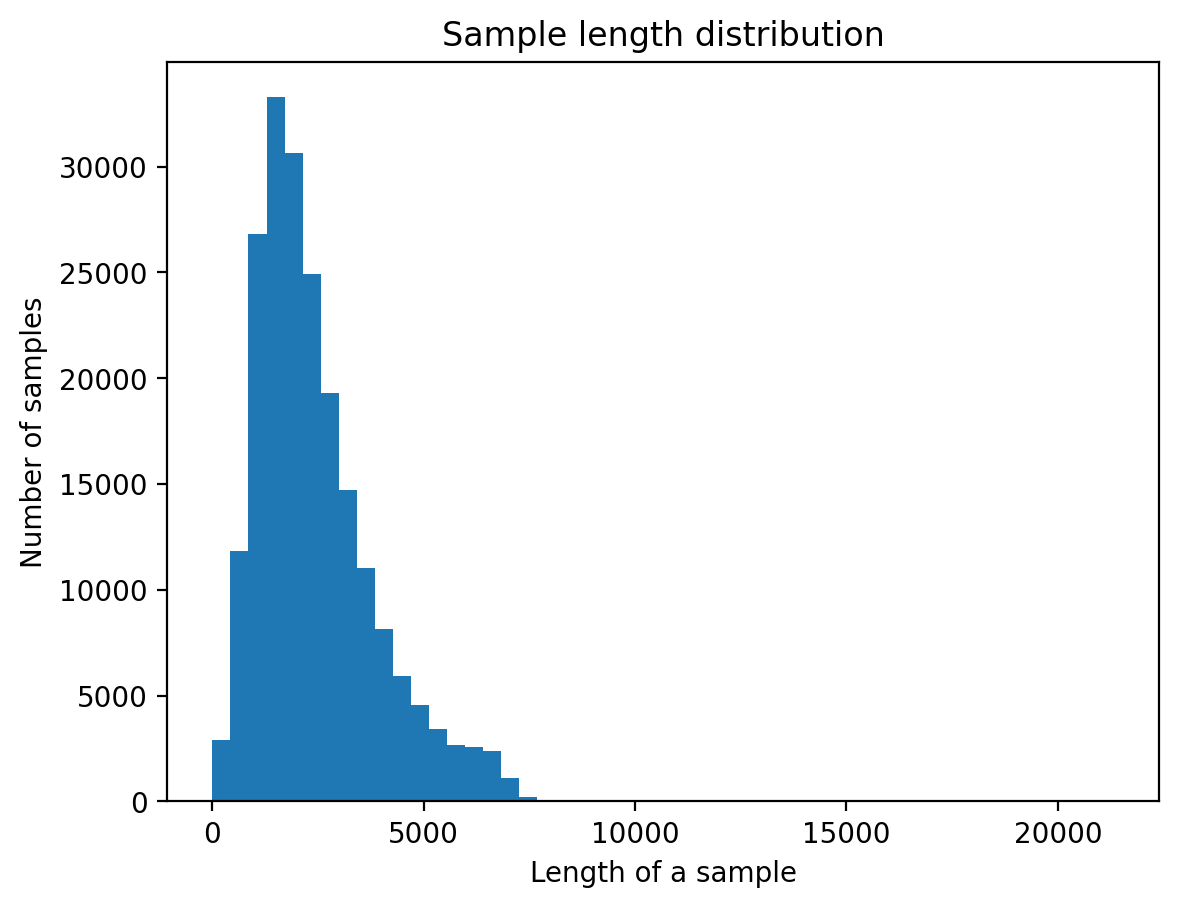

In [14]:
plot_sample_length_distribution(reviews["text"].values)

**Frequency distribution of words**: Distribution showing the frequency (number of occurrences) of each word in the dataset.

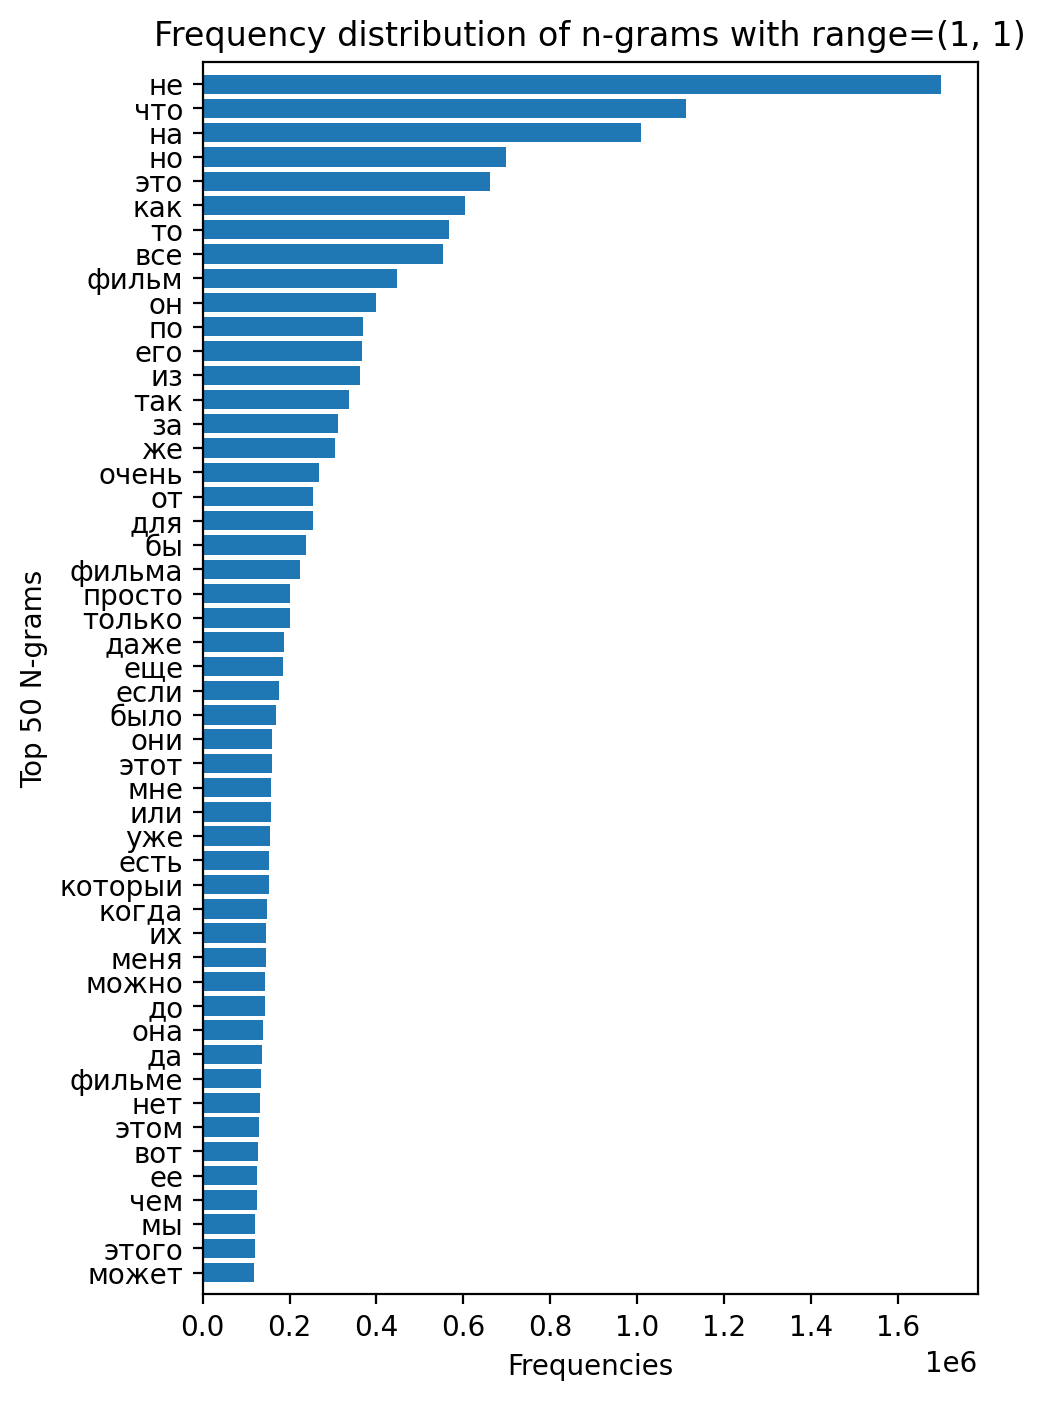

In [61]:
plot_frequency_distribution_of_ngrams(
    reviews["text"].values, ngram_range=(1, 1), num_ngrams=50
)

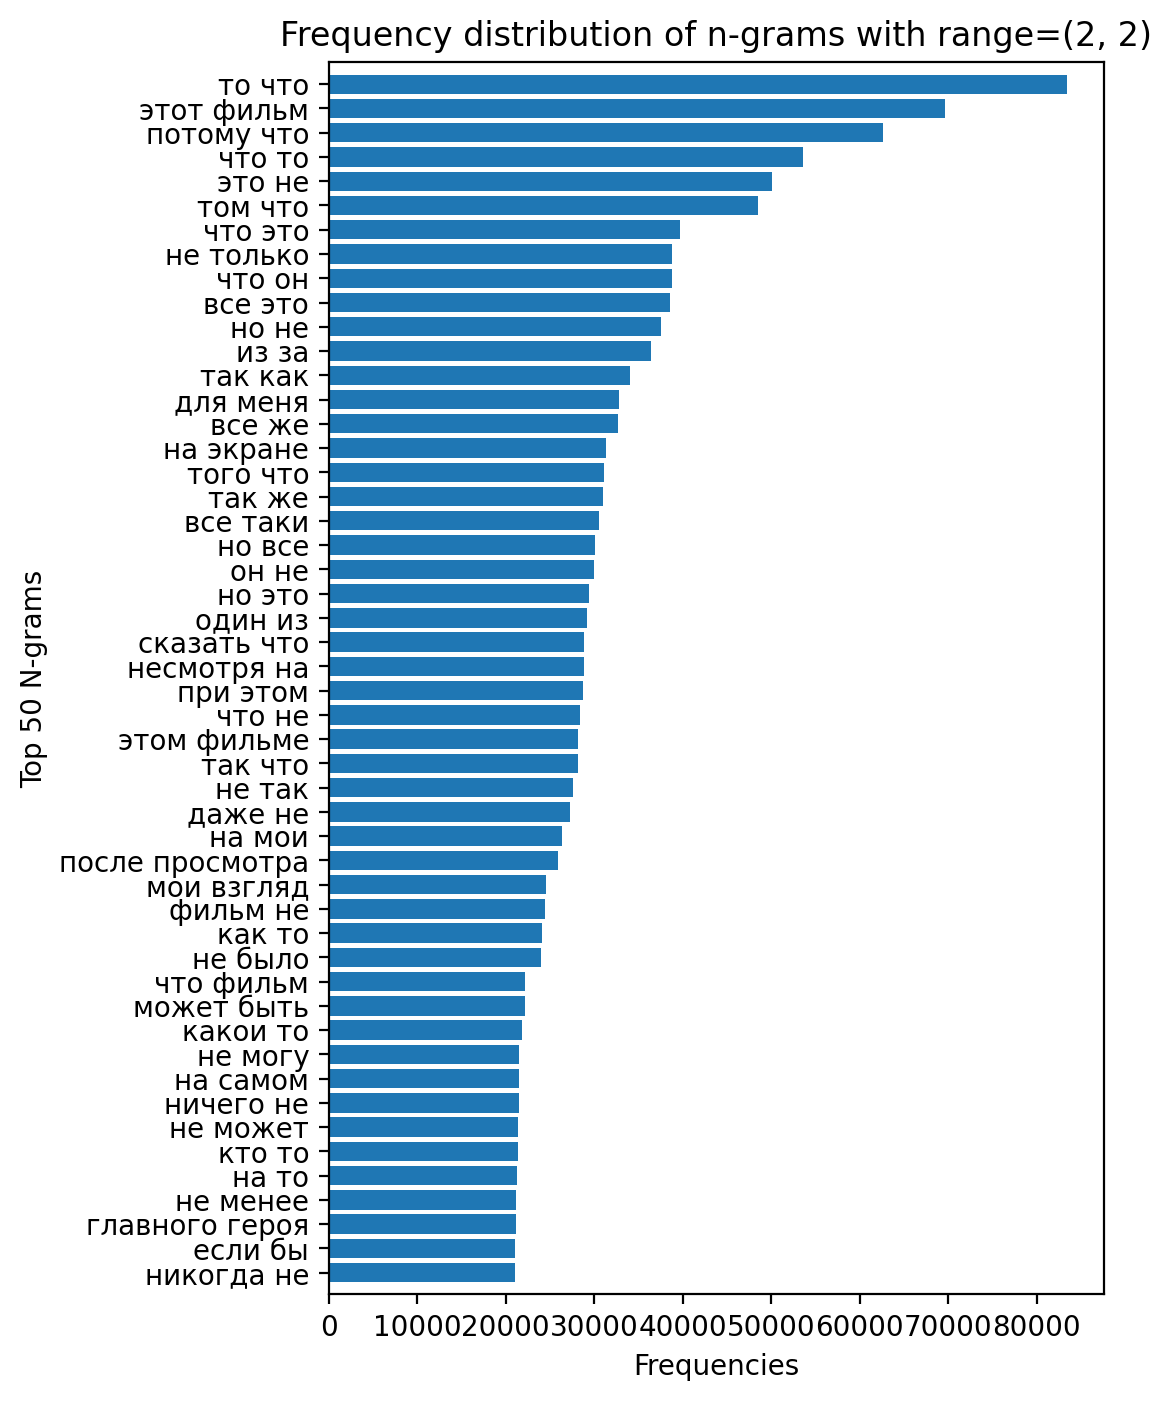

In [62]:
plot_frequency_distribution_of_ngrams(
    reviews["text"].values, ngram_range=(2, 2), num_ngrams=50
)

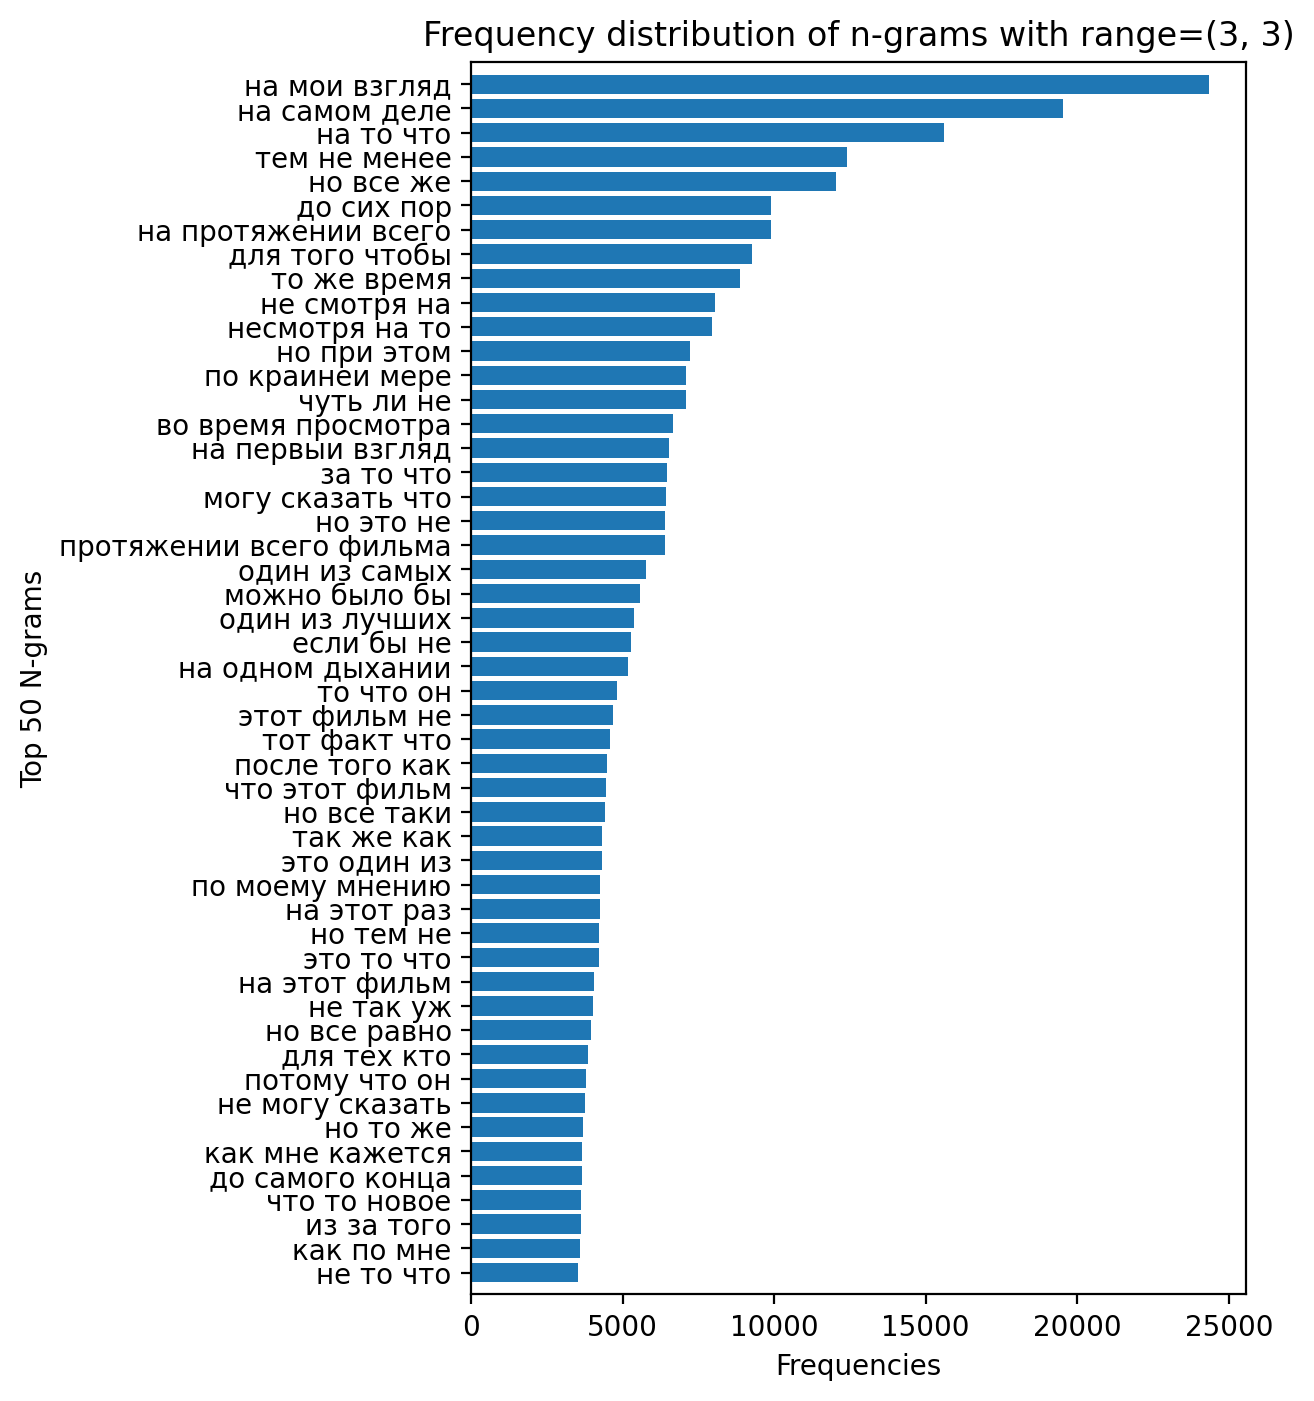

In [63]:
plot_frequency_distribution_of_ngrams(
    reviews["text"].values, ngram_range=(3, 3), num_ngrams=50
)